<a href="https://colab.research.google.com/github/hotafrosauce1/Youtube-Video-Classification-Regression/blob/master/Youtube_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# dbutils.library.installPyPI("keras")
# dbutils.library.installPyPI("tensorflow")
# dbutils.library.installPyPI("image")

# dbutils.library.restartPython()

In [1]:
# Standard Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pipelines for training and evaluating model
from sklearn.pipeline import Pipeline

# Preprocessing/Feature Extraction
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Models 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# Scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

import requests
from PIL import Image
from io import BytesIO
from keras.wrappers.scikit_learn import KerasClassifier
from keras.backend import clear_session

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# Converts JSON dictionary of Video Category Ids for 
# a given country into a DataFrame
def json_to_df(path):
    f = lambda x: x.loc['items']['snippet']['title']
    g = lambda x: x.loc['items']['snippet']['assignable']
    h = lambda x: x.loc['items']['id']
    
    df = pd.read_json(path)
    df['Category'] = df.apply(f, axis = 1)
    df['Assignable'] = df.apply(g, axis = 1)
    df['Id'] = df.apply(h, axis = 1)
    df['Id'] = df['Id'].astype(int)
    
    cols = ['Id', 'Category', 'Assignable']
    
    df = df[cols]
    
    return df[df['Assignable']]

In [3]:
%%time

countries = ['CA', 'GB', 'US']
data = pd.DataFrame({})

# Concatenating Data
for country in countries:
  
    country_youtube_video_data_path = '{}videos.csv'.format(country)
    country_category_id_path ='{}_category_id.json'.format(country)
    
    country_category_id_data = json_to_df(country_category_id_path)
    country_youtube_video_data = pd.read_csv(country_youtube_video_data_path)
    
    country_youtube_video_data['category_id'] = country_youtube_video_data['category_id'].astype(int)
    
    video_data_w_category = pd.merge(country_youtube_video_data, 
                                     country_category_id_data,
                                     left_on = 'category_id',
                                     right_on = 'Id')
    
    data = pd.concat([data, video_data_w_category])
    
data.head()

CPU times: user 1.69 s, sys: 190 ms, total: 1.88 s
Wall time: 4.32 s


In [4]:
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Id,Category,Assignable
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,10,Music,True
1,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,10,Music,True
2,H1KBHFXm2Bg,17.14.11,21 Savage - Bank Account (Official Music Video),21 Savage,10,2017-11-10T19:00:02.000Z,"21 savage|""bank account""|""21 savage bank accou...",5068229,263596,8585,28976,https://i.ytimg.com/vi/H1KBHFXm2Bg/default.jpg,False,False,False,Watch the official music video of Bank Account...,10,Music,True
3,7MxiQ4v0EnE,17.14.11,Daang ( Full Video ) | Mankirt Aulakh | Sukh S...,Speed Records,10,2017-11-11T16:41:15.000Z,"punjabi songs|""punjabi bhangra""|""punjabi music...",5718766,127477,7134,8063,https://i.ytimg.com/vi/7MxiQ4v0EnE/default.jpg,False,False,False,Song - Daang\nSinger - Mankirt Aulakh\nFaceboo...,10,Music,True
4,j67FgNEvyh8,17.14.11,Telefoon || Babbu Maan || Promo || Full Song 1...,Hey Yolo,10,2017-11-12T04:24:34.000Z,"Telefoon|""Babbu Maan""|""Mehfil Mitran Di""|""new ...",178447,4339,96,876,https://i.ytimg.com/vi/j67FgNEvyh8/default.jpg,False,False,False,"Full Song Out Now 15th November\n\nHey Yolo, S...",10,Music,True


In [5]:
le = LabelEncoder()
X, y = data.drop(['Category'], axis = 1), data['Category']
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 420)

print('Dataset Length: {}'.format(len(X)),'Training Data Length: {}'.format(len(X_train)),'Number of Response Categories: {}'.format(len(np.unique(y_train))))

Dataset Length: 120375 Training Data Length: 90281 Number of Response Categories: 15


In [7]:
%%time

def get_thumbnail(url): 
    r = requests.get(url).content
    img_data = Image.open(BytesIO(r))
    img_data = img_data.resize((50, 50))
    
    return np.array(img_data).reshape(1, 50, 50, 3)

# Download the Video thumbnails to use to predict video's category
img_data = X_train['thumbnail_link'].map(get_thumbnail)

img_data.head()

CPU times: user 16min 58s, sys: 50.3 s, total: 17min 49s
Wall time: 26min 50s


In [8]:
# Change shape of training data so it can be fed into model
img_data = np.concatenate([img_data.iloc[i] for i in range(len(img_data))])
img_data.shape

(90281, 50, 50, 3)

In [9]:
# Convert class labels into class vectors
y_train_img_model = np.array([y_train[i]
                              for i in range(len(y_train))
                            ])
                              
y_train_img_model = keras.utils.to_categorical(y_train_img_model, num_classes = 15)
y_train_img_model

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
# Dictionary to store different models' performances
model_dict = {'Model':[], 'Training Acc.':[], 'Validation Acc.':[]}

# Return training error and validation error for model
def get_train_val_error(model):
    scorer = make_scorer(accuracy_score)
    
    model.fit(X_train, y_train)

    preds = model.predict(X_train)
    training_acc = accuracy_score(y_train, preds)
    val_acc = np.mean(cross_val_score(model, X_train, y_train, scoring = scorer))

    return training_acc, val_acc

In [11]:
cols = ['title', 'tags', 'description']

# Data Pipeline for text-based model
model_text = Pipeline([
    ('Columns', ColumnTransformer([
        ('keep', 'passthrough', cols)
    ])),
    ('Imputation', SimpleImputer(strategy = 'constant', fill_value = '')),
    ('Bag of Words', ColumnTransformer([
        (cols[0], CountVectorizer(stop_words = 'english', max_features = 10000), 0),
        (cols[1], CountVectorizer(stop_words = 'english', max_features = 10000), 1),
        (cols[2], CountVectorizer(stop_words = 'english', max_features = 10000), 2)
    ])),
    ('TF-IDF', TfidfTransformer()),
    ('Model Text', LogisticRegression(multi_class = 'multinomial', solver = 'sag'))
])

model_text

Pipeline(memory=None,
         steps=[('Columns',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('keep', 'passthrough',
                                                  ['title', 'tags',
                                                   'description'])],
                                   verbose=False)),
                ('Imputation',
                 SimpleImputer(add_indicator=False, copy=True, fill_value='',
                               missing_values=nan, strategy='constant',
                               verbose=0)),
                ('Bag of Wor...
                ('TF-IDF',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('Model Text',
                 LogisticRegression(C=1.0, class_weight=N

In [12]:
# Get training and validation error of text-based model
model_text_train_err, model_text_val_err = get_train_val_error(model_text)

print('Training Accuracy: {}'.format(model_text_train_err))
print('Validation Accuracy: {}'.format(model_text_val_err))

Training Accuracy: 0.9650646315393051
Validation Accuracy: 0.9418039632729999


In [0]:
# Add text-based model's performance to the model dictionary
model_dict['Model'].append('Text Model (Baseline)')
model_dict['Training Acc.'].append(model_text_train_err)
model_dict['Validation Acc.'].append(model_text_val_err)

In [14]:
# Clear previous model weights and returns a blank baseline CNN model
# consisting of 10 feature maps, a 3x3 local receptive field, and the ReLU
# activaton function
def baseline_image_model():
    clear_session()
    
    model = Sequential()
    model.add(Conv2D(10, (3, 3), activation='relu', input_shape = (50, 50, 3)))
    model.add(Flatten())
    model.add(Dense(15, activation='softmax'))

    sgd = SGD(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
    
    return model

image_model = baseline_image_model()
image_model

In [15]:
# Return validation accuracies for image-based model
def cross_val_score_custom(X_train_img, y_train_img):
    from sklearn.model_selection import KFold
    
    kfold = KFold(n_splits = 3)
    val_accs = []
    
    for train_index, val_index in kfold.split(X_train_img):
        new_model = baseline_image_model()
        
        new_model.fit(X_train_img[train_index],
                      y_train_img[train_index],
                      epochs = 5,
                      batch_size = 128)
        
        val_error, val_acc = new_model.evaluate(X_train_img[val_index], y_train_img[val_index])
        val_accs.append(val_acc)
        
    return val_accs

# Return training and validation accuracy of image-based model
def get_train_val_error_image_model(image_model):
    image_model.fit(img_data / 255, y_train_img_model, epochs = 5)
    
    train_err, train_acc = image_model.evaluate(img_data / 255, y_train_img_model)
    val_acc = np.mean(cross_val_score_custom(img_data / 255, y_train_img_model))
    
    return train_acc, val_acc


# Get training and validation error of image-based model
train_acc_image_model, val_acc_image_model = get_train_val_error_image_model(image_model)

Epoch 1/5
90281/90281 [==============================] - 53s 588us/step - loss: 2.1734 - accuracy: 0.3280
Epoch 2/5
90281/90281 [==============================] - 54s 599us/step - loss: 2.0213 - accuracy: 0.3572
Epoch 3/5
90281/90281 [==============================] - 54s 598us/step - loss: 1.9409 - accuracy: 0.3759
Epoch 4/5
90281/90281 [==============================] - 54s 604us/step - loss: 1.8708 - accuracy: 0.3998
Epoch 5/5
90281/90281 [==============================] - 28s 311us/step
Epoch 1/5
60187/60187 [==============================] - 30s 493us/step - loss: 2.2595 - accuracy: 0.3072
Epoch 2/5
60187/60187 [==============================] - 29s 476us/step - loss: 2.1839 - accuracy: 0.3273
Epoch 3/5
60187/60187 [==============================] - 29s 485us/step - loss: 2.1308 - accuracy: 0.3352
Epoch 4/5
60187/60187 [==============================] - 29s 489us/step - loss: 2.0857 - accuracy: 0.3421
Epoch 5/5
30094/30094 [==============================] - 7s 247us/step
Epoch 1/5

In [23]:
print('Training accuracy for baseline image-based model: {}'.format(train_acc_image_model))
print('Validation accuracy for baseline image-based model: {}'.format(val_acc_image_model))

Training accuracy for baseline image-based model: 0.4494079649448395
Validation accuracy for baseline image-based model: 0.335342009862264


In [0]:
# Add image-based model's performance to the model dictionary

model_dict['Model'].append('Img Model (Baseline)')
model_dict['Training Acc.'].append(train_acc_image_model)
model_dict['Validation Acc.'].append(val_acc_image_model)

In [21]:
model_performance = pd.DataFrame(model_dict, index = model_dict['Model'])
model_performance

,Model,Training Acc.,Validation Acc.
Text Model (Baseline),Text Model (Baseline),0.965065,0.941804
Img Model (Baseline),Img Model (Baseline),0.449408,0.335342


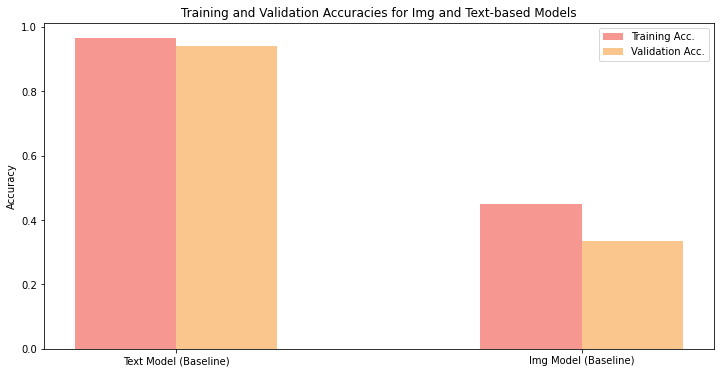

In [22]:
pos = list(range(len(model_performance))) 
width = 0.25 
fig, ax = plt.subplots(figsize = (12,6))

plt.bar(pos, 
        model_performance['Training Acc.'], 
        width, 
        alpha=0.5, 
        color='#EE3224', 
        align = 'center',
        label=model_performance['Model'][0]) 
plt.bar([p + width for p in pos], 
        model_performance['Validation Acc.'],
        width, 
        alpha=0.5, 
        color='#F78F1E',
        align = 'center',
        label=model_performance['Model'][1]) 

ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracies for Img and Text-based Models')
ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_xticklabels(model_performance['Model'], ha = 'center')

plt.legend(['Training Acc.', 'Validation Acc.'], loc='upper right')

## Summary



*   Text-based model (Baseline)
            Training Accuracy: 96.50%
            Validation Accuracy: 94.18%

*   Image-based model (Baseline)
            Training Accuracy: 44.94%
            Validation Accuracy: 33.53%


# To-do



*   Train/test a more complex text-based model than baseline model (ANN, CNN, SVM)
*   Train/test a more complex CNN architecture for image-based model

